### Q1 & Q2

In [90]:
import numpy as np
from skimage import io
from skimage import util
import matplotlib.pyplot as plt
from scipy import ndimage
from matplotlib.colors import hsv_to_rgb

%matplotlib inline

img_t0 = io.imread("images/taxi15.png")
img_t1 = io.imread("images/taxi16.png")
img_t0 = util.img_as_ubyte(img_t0).astype('float')
img_t1 = util.img_as_ubyte(img_t1).astype('float')

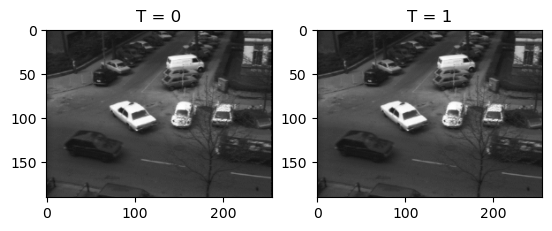

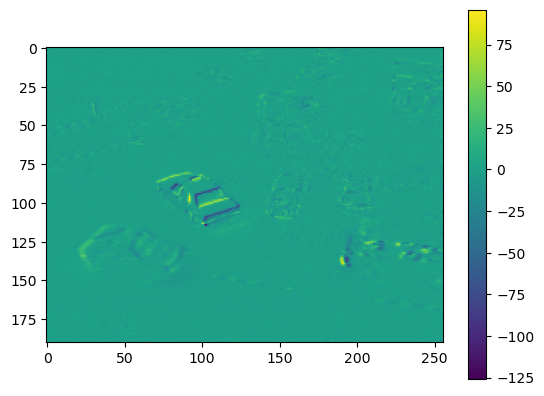

In [91]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img_t0, cmap='gray')
ax[0].set_title('T = 0')
ax[1].imshow(img_t0, cmap='gray')
ax[1].set_title('T = 1')
plt.show()

delta = img_t1-img_t0
plt.figure()
plt.imshow(delta)
plt.colorbar()
plt.show()



### Q3

In [92]:
Gx = 1/2 * np.array([[1, 0, -1]])
Gy = Gx.T

I_dx = ndimage.convolve(img_t0, Gx)
I_dy = ndimage.convolve(img_t0, Gy)

### Q4 & Q5

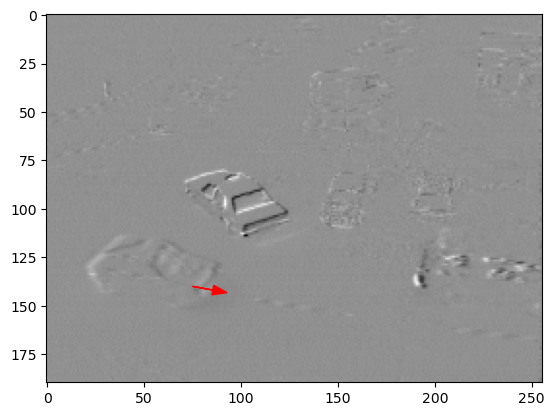

In [93]:
def flot(delta, dx, dy, u, v, N):
    x = np.arange(u - N//2, u + N//2 + 1, 1)
    y = np.arange(v - N//2, v + N//2 + 1, 1)

    ux, vy = np.meshgrid(x, y)

    delta = delta[ux, vy].flatten()
    dx = dx[ux, vy].flatten()
    dy = dy[ux, vy].flatten()

    A = -np.array([dx, dy]).T
    B = np.array([delta]).T

    d = np.linalg.inv(A.T @ A) @ A.T @ B
    return d


u = 140
v = 75
N = 5
d = flot(delta, I_dx, I_dy, u, v, N)

plt.figure()
plt.imshow(delta, cmap='gray')
plt.arrow(v, u, 10 * d[0].item(), 10 * d[1].item(), head_width=5, length_includes_head=True, color='r')

### Q6 & Q7.a

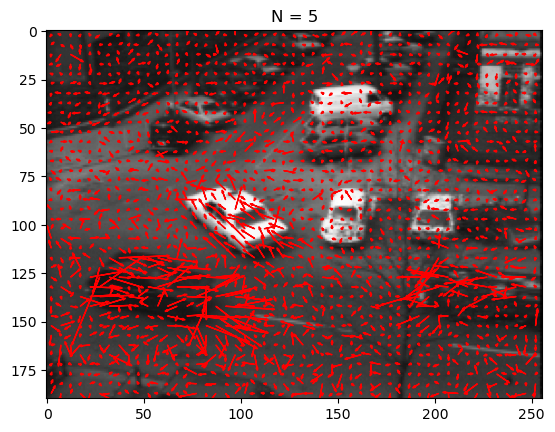

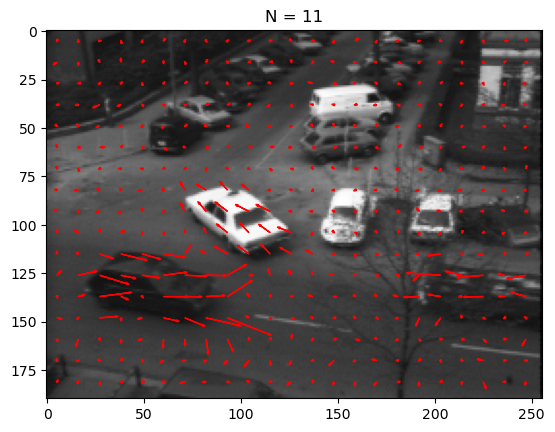

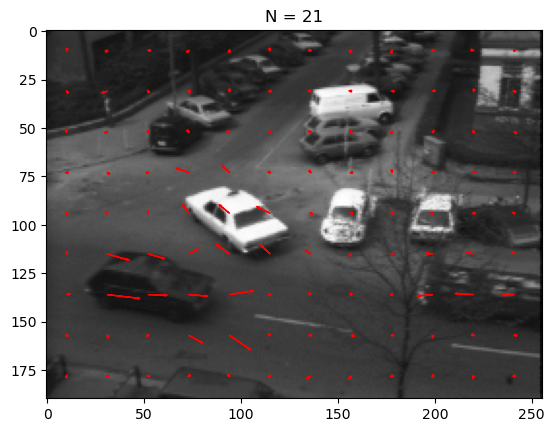

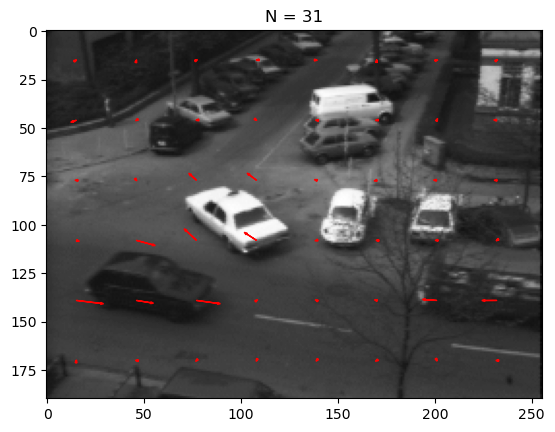

In [94]:
amplification = 8

for N in [5,11, 21, 31]:
    plt.figure()
    X = np.arange(0 + N//2, delta.shape[0] - N//2, N)
    Y = np.arange(0 + N//2, delta.shape[1] - N//2, N)
    
    for u in X:
        for v in Y:
            d = flot(delta, I_dx, I_dy, u, v, N)
            plt.arrow(v, u, amplification*d[0].item(), amplification*d[1].item(), head_width=1, length_includes_head=True, fc='r', ec='r')

    plt.imshow(img_t0, cmap='gray')
    plt.title('N = ' + str(N))
    plt.show()

N = 11 et N = 21 donnent les meilleurs résultats.

### Q7.b bonus

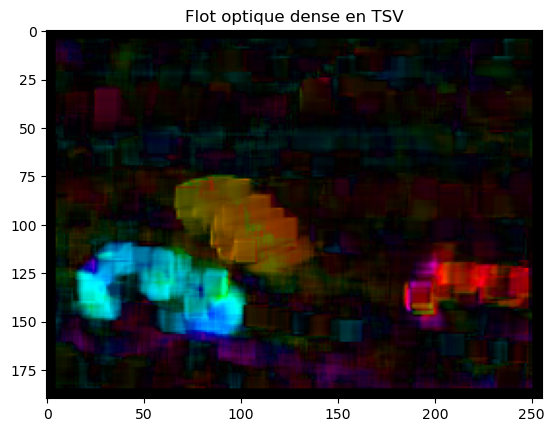

In [95]:
def flot_to_hsv(flot_x, flot_y, amax):
    # Calculer l'amplitude et l'angle des vecteurs de déplacement
    amplitude = np.sqrt(flot_x**2 + flot_y**2)
    angle = np.arctan2(flot_y, flot_x)

    # Normaliser l'angle entre 0 et 1
    angle = (angle + np.pi) / (2 * np.pi)

    # Borner l'amplitude entre 0 et 1
    amplitude = np.minimum(amplitude / amax, 1)

    # Définir la saturation et la valeur des couleurs
    saturation = np.ones_like(amplitude)
    value = amplitude

    # Convertir les couleurs de l'espace TSV à l'espace RVB
    rgb = hsv_to_rgb(np.stack([angle, saturation, value], axis=-1))

    return rgb

# Paramètres du flot optique dense
amax = 10  # Amplitude maximale représentée
N = 11  # Rayon de la fenêtre d'observation
amplification = 5

# Calculer le flot optique dense
flot_x = np.zeros_like(delta)
flot_y = np.zeros_like(delta)
for u in range(N//2, delta.shape[0] - N//2):
    for v in range(N//2, delta.shape[1] - N//2):
        d = flot(delta, I_dx, I_dy, u, v, N)
        flot_x[u, v] = amplification*d[0].item()
        flot_y[u, v] = amplification*d[1].item()

# Convertir le flot optique en couleurs TSV
rgb = flot_to_hsv(flot_x, flot_y, amax)

# Afficher le résultat
plt.imshow(rgb)
plt.title('Flot optique dense en TSV')
plt.show()


### Q8

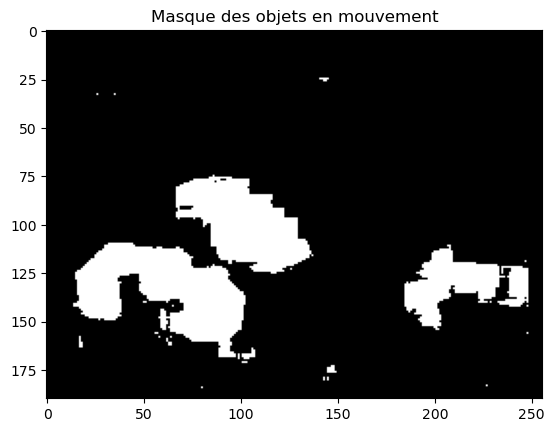

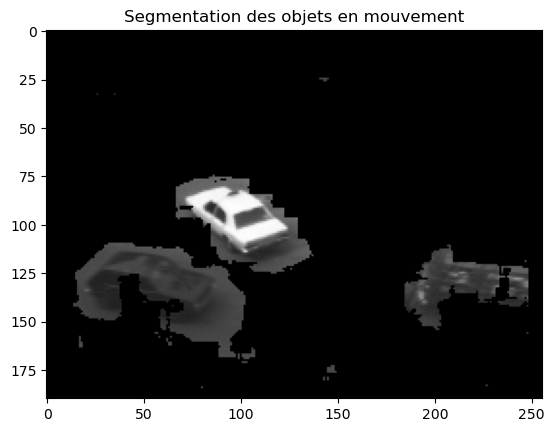

In [96]:
amplitude = np.sqrt(flot_x**2 + flot_y**2)
seuil = 3
masque = amplitude > seuil

plt.imshow(masque, cmap='gray')
plt.title('Masque des objets en mouvement')
plt.show()

segmentation = np.copy(img_t0)
segmentation[~masque] = 0

plt.imshow(segmentation, cmap='gray')
plt.title('Segmentation des objets en mouvement')
plt.show()

### Q9 bonus

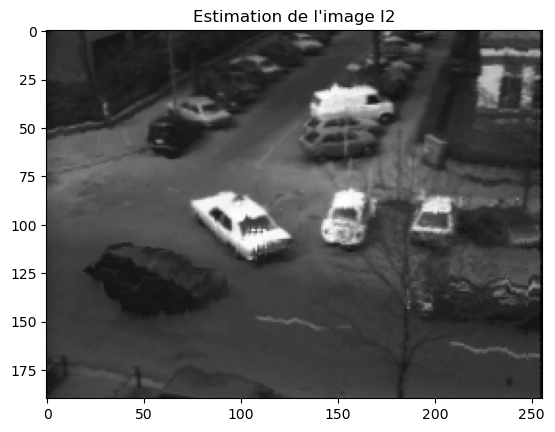

In [97]:
# Définir les coordonnées des pixels de l'image I1
x, y = np.meshgrid(np.arange(img_t0.shape[0]), np.arange(img_t0.shape[1]))

# Calculer les coordonnées des pixels de l'image I2 en utilisant le flot optique
x2 = x.T + flot_x
y2 = y.T + flot_y

# Définir les coordonnées des pixels de l'image I2 sous forme de tableau
coords = np.stack([x2.ravel(), y2.ravel()], axis=0)

# Interpoler les valeurs des pixels de l'image I1 aux coordonnées des pixels de l'image I2
I2_bis = ndimage.map_coordinates(img_t0, coords, order=1).reshape(img_t0.shape)

# Afficher l'estimation de l'image I2
plt.imshow(I2_bis, cmap='gray')
plt.title('Estimation de l\'image I2')
plt.show()
